# Autoencoders

Source: https://avandekleut.github.io/vae/

## Manifold Hypothesis

> The Manifold Hypothesis states that real-world high-dimensional data lie on low-dimensional manifolds embedded within the high-dimensional space.

![](https://d3i71xaburhd42.cloudfront.net/8dc7a7af1685d6667d24f013ecc5fceeb2bcc689/7-Figure2-1.png)

Source: https://www.semanticscholar.org/paper/A-Survey-of-Dimension-Reduction-Methods-for-Data-Engel-H%C3%BCttenberger/8dc7a7af1685d6667d24f013ecc5fceeb2bcc689

## PCA

In PCA we did: $$Z = XW^T$$ or $$X = ZW$$

We want to do the same thing in a more sophisticated manner:

- Given $x$, predict $x$.

![](https://avandekleut.github.io/assets/vae/autoencoder.png)

Why autoencoders?

- Deep networks
- Learn abstract features
- Encoder can be different than decoder

In [1]:
import torch
from pygments.formatters import img

torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [3]:
class Encoder(nn.Module):
    def __init__(self, latent_dims):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(28 * 28, 512)
        self.linear2 = nn.Linear(512, latent_dims)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        return self.linear2(x)

In [4]:
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, 28 * 28)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 1, 28, 28))

In [5]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [6]:
def train(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in tqdm(range(epochs)):
        for x, y in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum()
            loss.backward()
            opt.step()
    return autoencoder

In [7]:
latent_dims = 2
autoencoder = Autoencoder(latent_dims).to(device) # GPU

dataset = torchvision.datasets.MNIST('./data',
                             transform=torchvision.transforms.ToTensor(),
                             download=True)

data = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)

autoencoder = train(autoencoder, data)

100%|██████████| 20/20 [01:00<00:00,  3.04s/it]


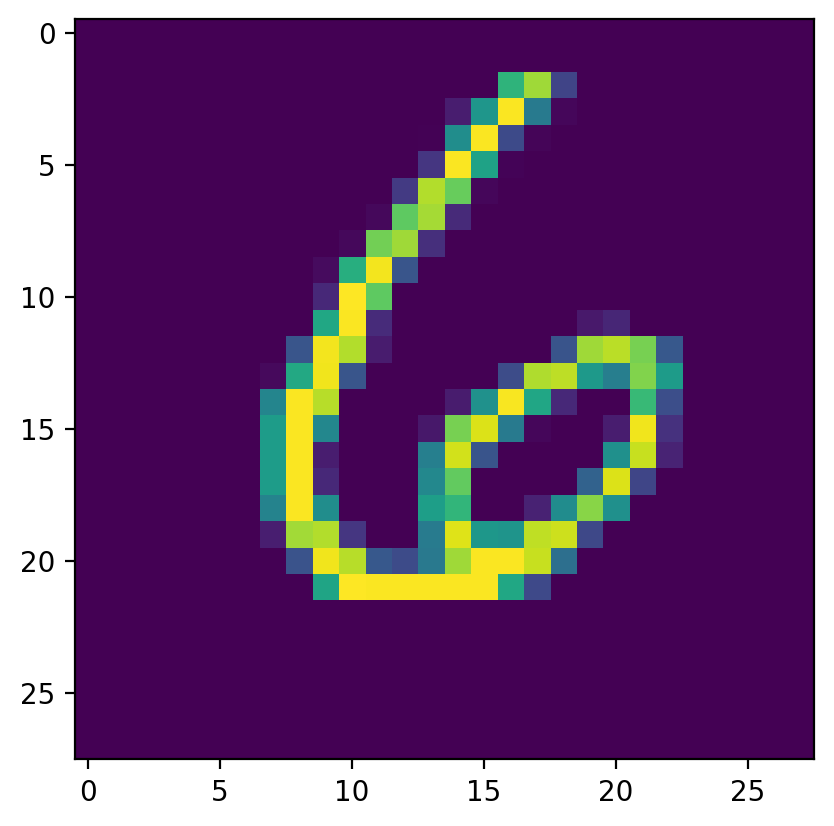

In [17]:
batch = next(iter(data))[0]
x = batch[0]
x_img = x.reshape(28, 28).to('cpu').detach().numpy()
plt.imshow(x_img)

In [18]:
z = autoencoder.encoder(x.to(device))
z

tensor([[ 0.5969, -1.6314]], device='mps:0', grad_fn=<LinearBackward0>)

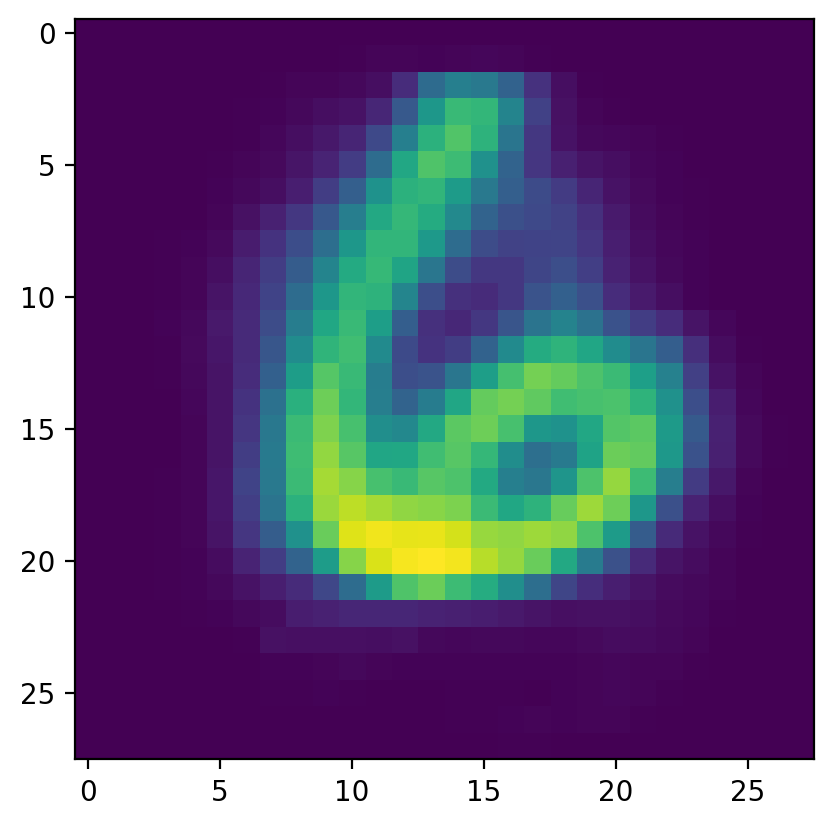

In [19]:
x_hat = autoencoder.decoder(z)
x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
plt.imshow(x_hat)

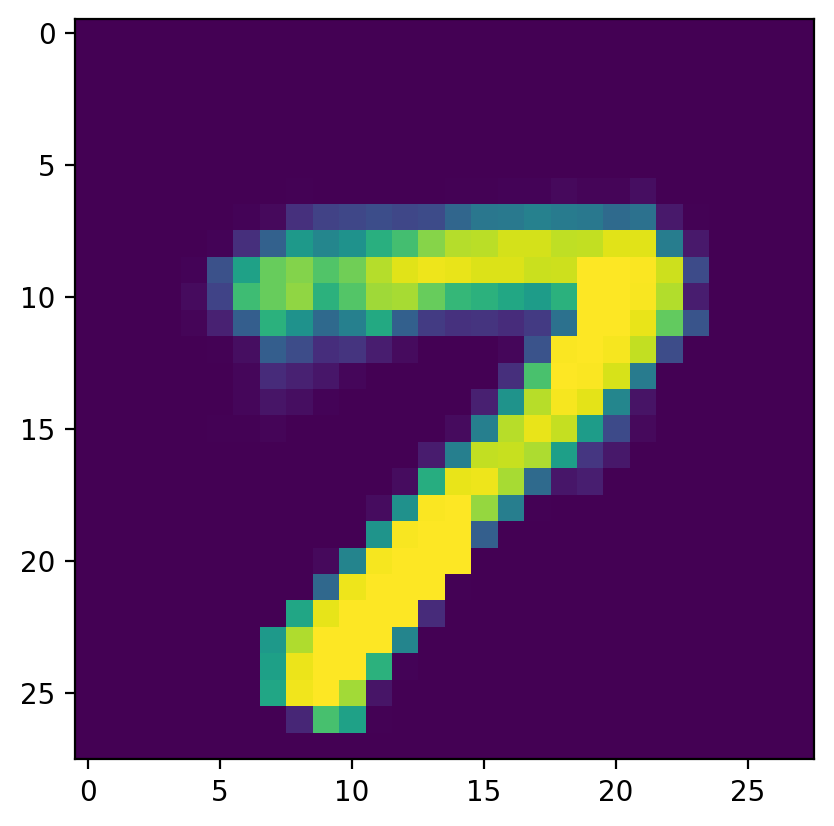

In [28]:
latent_point = torch.Tensor([-10, -5]).to(device)
x_hat = autoencoder.decoder(latent_point)
x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
plt.imshow(x_hat)

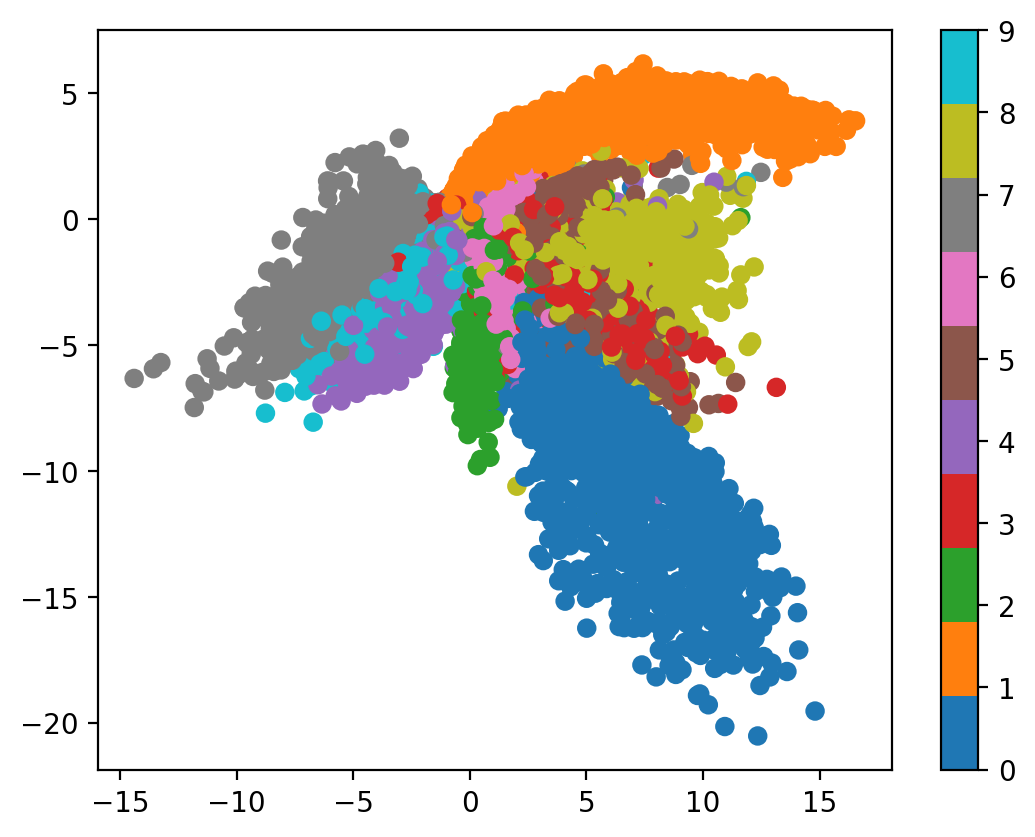

In [26]:
def plot_latent(autoencoder, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        z = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break

plot_latent(autoencoder, data)

In [31]:
def plot_reconstructed(autoencoder, r0=(-15, 15), r1=(-20, 10), n=24):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = autoencoder.decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])

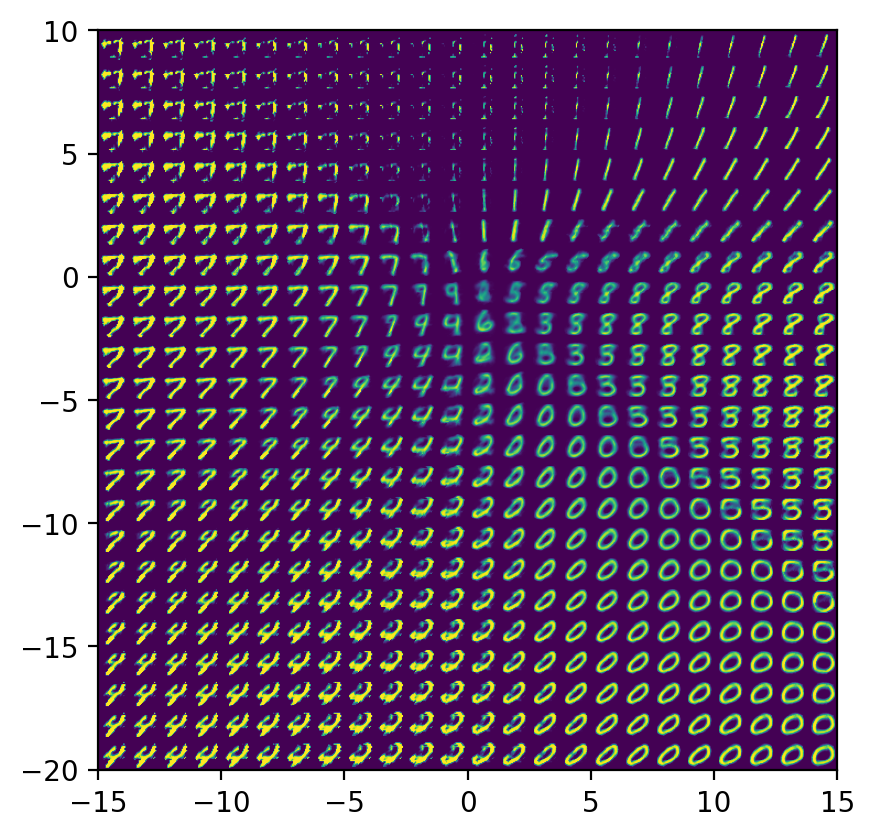

In [32]:
plot_reconstructed(autoencoder)

# Variational Autoencoder

Issues with deterministic autoencoders:

- Proximity in data space does not mean proximity in latent space
- Latent space may not be continuous
- How to measure the goodness of a reconstruction?
- For images we have the same issues with invariance to shifting, scaling, rotation, etc.


Introduce Variational Autoencoders (VAE):

- Encode inputs with some uncertainty
  - Encoder should output a probability distribution
  - Learns a vector of means and a vector of standard deviations
  - They paramaterize a Gaussian

![](https://avandekleut.github.io/assets/vae/variational-autoencoder.png)

![](vae.png)

In [33]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, latent_dims)
        self.linear3 = nn.Linear(512, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.to(device) # hack to get sampling on the GPU
        self.N.scale = self.N.scale.to(device)
        self.kl = 0

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)

        # Kl divergence between two normal distribtutions N(u, sigma^2) and N(0, 1).
        # Proof here: https://statproofbook.github.io/P/norm-kl.html 
        self.kl = 0.5*(sigma**2 + mu**2 - 2*torch.log(sigma) - 1.).sum()
        return z

In [34]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

## Training

- KL - Penalize if we are too far away from the standard normal
- Encourage latent vectors to be centralized

In [35]:
def train(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in tqdm(range(epochs)):
        for x, y in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)

            # loss has two terms:
            # 1. Reconstruction loss
            # 2. KL divergence
            loss = ((x - x_hat)**2).sum() + autoencoder.encoder.kl
            loss.backward()
            opt.step()
    return autoencoder

In [36]:
vae = VariationalAutoencoder(latent_dims).to(device) # GPU
vae = train(vae, data)

100%|██████████| 20/20 [01:08<00:00,  3.44s/it]


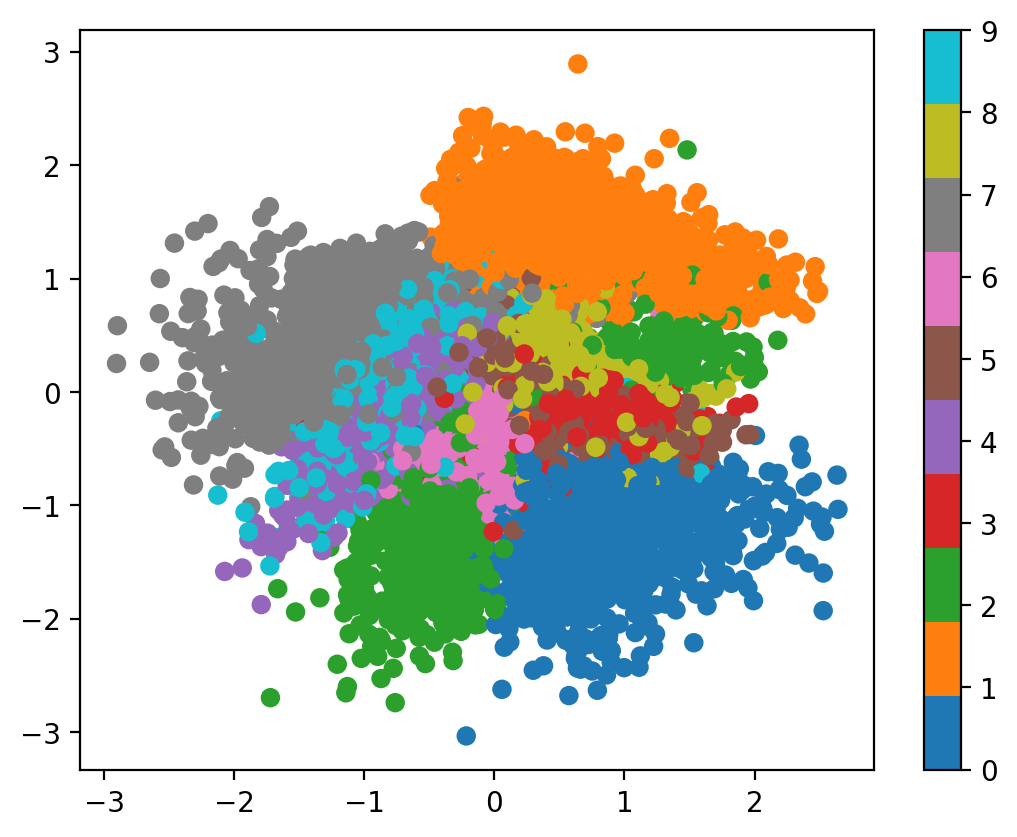

In [37]:
plot_latent(vae, data)

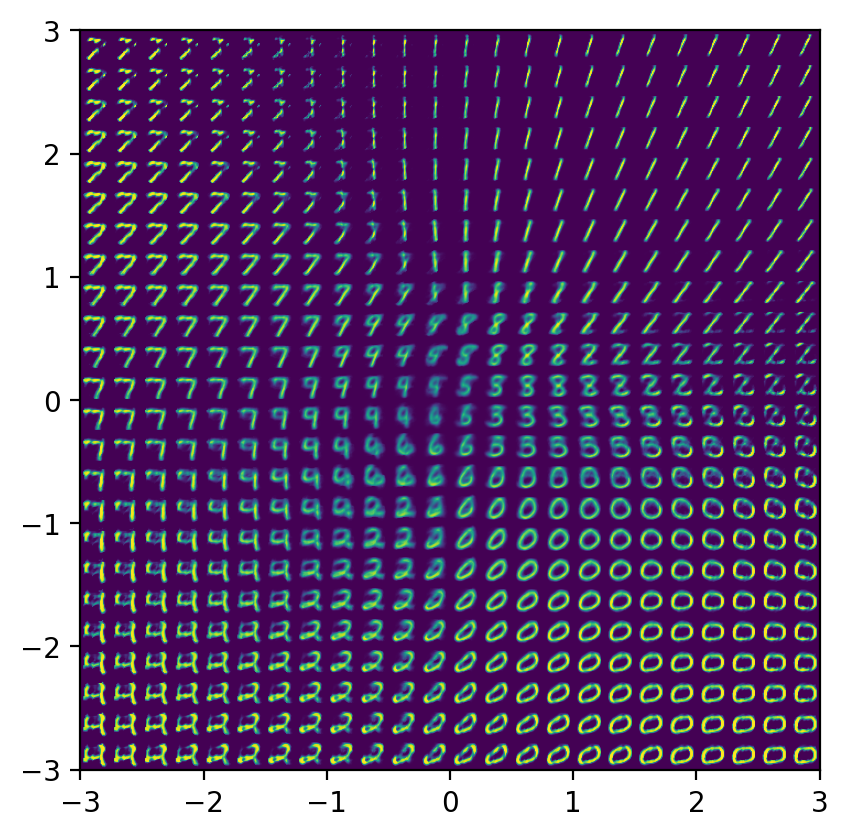

In [38]:
plot_reconstructed(vae, r0=(-3, 3), r1=(-3, 3), n=24)

# Interpolation

In [39]:
def interpolate(autoencoder, x_1, x_2, n=12):
    z_1 = autoencoder.encoder(x_1)
    z_2 = autoencoder.encoder(x_2)
    z = torch.stack([z_1 + (z_2 - z_1)*t for t in np.linspace(0, 1, n)])
    interpolate_list = autoencoder.decoder(z)
    interpolate_list = interpolate_list.to('cpu').detach().numpy()

    w = 28
    img = np.zeros((w, n*w))
    for i, x_hat in enumerate(interpolate_list):
        img[:, i*w:(i+1)*w] = x_hat.reshape(28, 28)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])

In [60]:
x, y = next(iter(data)) # hack to grab a batch
x_1 = x[y == 1][1].to(device) # find a digit 1
x_2 = x[y == 0][1].to(device) # find a digit 0

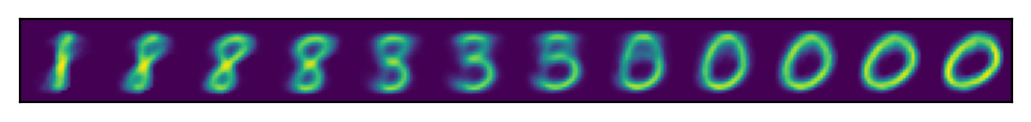

In [61]:
interpolate(vae, x_1, x_2, n=12)

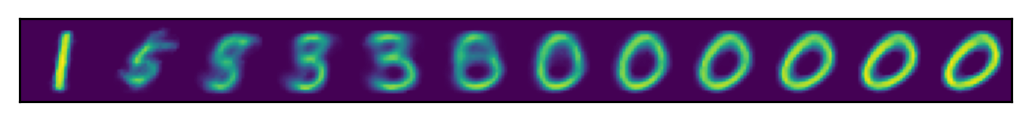

In [62]:
interpolate(autoencoder, x_1, x_2, n=12)

In [63]:
from PIL import Image

def interpolate_gif(autoencoder, filename, x_1, x_2, n=100):
    z_1 = autoencoder.encoder(x_1)
    z_2 = autoencoder.encoder(x_2)

    z = torch.stack([z_1 + (z_2 - z_1)*t for t in np.linspace(0, 1, n)])

    interpolate_list = autoencoder.decoder(z)
    interpolate_list = interpolate_list.to('cpu').detach().numpy()*255

    images_list = [Image.fromarray(img.reshape(28, 28)).resize((256, 256)) for img in interpolate_list]
    images_list = images_list + images_list[::-1] # loop back beginning

    images_list[0].save(
        f'{filename}.gif',
        save_all=True,
        duration=100,
        append_images=images_list[1:],
        loop=1)

In [64]:
interpolate_gif(vae, "vae", x_1, x_2)

![](vae.gif)

![](vae.gif)

## Application: Image Denoising

![](denoise.png)
